# PREDICTING SEPSIS RISK DURING IN-PATIENT ADMISSIONS
*Client: Royal Perth Hospital*

*Team: Group 7*

# Readme
The following libraries need to be installed in order to run the source code.

In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from importlib import reload

# os.chdir('D:/Kha/UWA/CITS5553/sepsis_prediction/data-science-capstone-project/Kha Huynh')
import my_util
reload(my_util)
import load_parquet as load_df
reload(load_df)
import gpt_utils as gpt_utils
reload(gpt_utils)

np.warnings = warnings
# os.chdir('D:/Kha/UWA/CITS5553/sepsis_prediction/data-science-capstone-project')

ROOT_DIR = Path('../..')

# 1.Dataset Processing

## 1.1 Data Cleaning

Load the dataset. The following tables are loaded for this project:
- PATIENTS
- ADMISSIONS
- DIAGNOSES_ICD
- LABEVENTS
- MICROBIOLOGYEVENTS
- D_ICD_DIAGNOSES
- D_ITEMS

In [2]:
# load transaction dataset
df_patients = pd.read_csv(ROOT_DIR / 'data\PATIENTS.csv')
df_admissions = pd.read_csv(ROOT_DIR / 'data\ADMISSIONS.csv')
df_diagnoses_icd = pd.read_csv(ROOT_DIR / 'data\DIAGNOSES_ICD.csv')
# df_labevents = pd.read_csv(ROOT_DIR / 'data\LABEVENTS.csv')
df_labevents = pd.read_csv(ROOT_DIR / 'data\labevents_cleaned.csv')
df_microbiologyevents = pd.read_csv(ROOT_DIR / 'data\MICROBIOLOGYEVENTS.csv')

# load description tables
df_desc_icd = pd.read_csv(ROOT_DIR / 'data\D_ICD_DIAGNOSES.csv')
df_desc_labitems = pd.read_csv(ROOT_DIR / 'data\D_LABITEMS.csv')
df_desc_items = pd.read_csv(ROOT_DIR / 'data\D_ITEMS.csv')

In [3]:
# Convert the following datetime columns to datetime format
# patients: DOB to date format, we not care about the birth time
df_patients['DOB'] = pd.to_datetime(df_patients['DOB'], format='%Y-%m-%d %H:%M:%S')
# admissions: ADMITTIME, DISCHTIME, EDREGTIME, EDOUTTIME
df_admissions['ADMITTIME'] = pd.to_datetime(df_admissions['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
df_admissions['DISCHTIME'] = pd.to_datetime(df_admissions['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')
df_admissions['EDREGTIME'] = pd.to_datetime(df_admissions['EDREGTIME'], format='%Y-%m-%d %H:%M:%S')
df_admissions['EDOUTTIME'] = pd.to_datetime(df_admissions['EDOUTTIME'], format='%Y-%m-%d %H:%M:%S')
# labevents: CHARTTIME
df_labevents['CHARTTIME'] = pd.to_datetime(df_labevents['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')
# microbiologyevents: CHARTDATE to date format and CHARTTIME to datetime format
# df_microbiologyevents['CHARTDATE'] = pd.to_datetime(df_microbiologyevents['CHARTDATE'], format='%Y-%m-%d')
df_microbiologyevents['CHARTTIME'] = pd.to_datetime(df_microbiologyevents['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')

The DIAGNOSES_ICD tables has a column ICD9_CODE which is the code for each disease diagnosed for the patient.

The Sepsis has 6 codes: ['77181', '99591', '99592', '67020', '67022', '67024']

We'll introduce a new column, IS_SEPSIS, as a binary classifier (1 for 6 sepsis ICD9 codes, 0 otherwise) for the target variable.

In [221]:
# retrieve all sepsis icd code
sepsis_icd =  df_desc_icd[df_desc_icd.apply(lambda x:'seps' in x['SHORT_TITLE'].lower(),axis=1)]['ICD9_CODE'].values
# add new binary classifier target variable
df_diagnoses_icd['IS_SEPSIS'] = df_diagnoses_icd.apply(lambda x: 1 if x['ICD9_CODE'] in sepsis_icd else x['ICD9_CODE'], axis=1)

In [4]:
try:
    df_demographic = pd.read_csv(ROOT_DIR / 'data/demographic.csv')
except:
    # merge the patients and admission tables to a demographic dataframe
    df_demographic = pd.merge(df_admissions, df_patients[['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG']], on='SUBJECT_ID')
    # create an age column to each case
    df_demographic['AGE'] = (((df_demographic['ADMITTIME'].dt.date - df_demographic['DOB'].dt.date) // 365) / pd.Timedelta(days=1)).astype('int16')
    # add column IS_SEPSIS to demographic data indicating which case is diagnosed with sepsis
    df_demographic['IS_SEPSIS'] = df_demographic.apply(lambda x: my_util.check_sepsis(x['SUBJECT_ID'], x['HADM_ID'], df_diagnoses_icd), axis=1)
    my_util.save_csv(df_demographic, ROOT_DIR / 'data/demographic.csv')
# convert admittime and dischtime to datetime
df_demographic['ADMITTIME'] = pd.to_datetime(df_demographic['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
df_demographic['DISCHTIME'] = pd.to_datetime(df_demographic['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')

there are 5406 admissions has IS_SEPSIS=1.

But in the df_diagnoses_icd has 5409. The code below found that 3 HADM_ID is diagnosed sespsis 2 twice (with the same/different sepsis icd9_code)

In [7]:
# there are 3 HADM_ID are predicted sepsis twice in diagnoses table
df_diagnoses_icd[df_diagnoses_icd['IS_SEPSIS'] == 1]['HADM_ID'][df_diagnoses_icd[df_diagnoses_icd['IS_SEPSIS'] == 1]['HADM_ID'].duplicated()]

27720     124907
410048    124482
639237    107047
Name: HADM_ID, dtype: int64

#### Unpivot the labevents table - due to memory crash, this code cannot be executed

In [71]:
# no need to run this
df_labevents_processed = df_labevents.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID', 'CHARTTIME'], ignore_index=True)[['SUBJECT_ID', 'HADM_ID', 'CHARTTIME']]
my_util.save_csv(df_labevents_processed, 'data\output_csv\df_labevents_processed.csv')

In [10]:
df_labevents_processed = pd.read_csv("data\output_csv\df_labevents_processed.csv")
df_labevents_processed['CHARTTIME'] = pd.to_datetime(df_labevents_processed['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')
df_labevents_processed['HADM_ID'] = df_labevents_processed['HADM_ID'].astype('Int64')

In [12]:
# no need to run this code
df_labevents_processed = my_util.create_labevent_columns(df_labevents_processed, df_desc_labitems[:300]['ITEMID'])
my_util.save_csv(df_labevents_processed, 'data\output_csv\df_labevents_processed_51346_50972.csv')

In [ ]:
# no need to run this code
df_labevents_processed = my_util.create_labevent_columns(df_labevents_processed, df_desc_labitems[300:]['ITEMID'])
my_util.save_csv(df_labevents_processed, 'data\output_csv\df_labevents_processed_50973_51555.csv')

In [ ]:
def add_column(df_labevents_processed, data):
    for i, x in data.iterrows():
        subject_id = x['SUBJECT_ID']
        hadm_id = x['HADM_ID']
        charttime = x['CHARTTIME']
        item_id = x['ITEM_ID']
        flag = x['FLAG']
        value = x['VALUE']
        r_index = df_labevents_processed[(df_labevents_processed.SUBJECT_ID == subject_id) & (df_labevents_processed.HADM_ID==hadm_id) &
         (df_labevents_processed.CHARTTIME==charttime)].index
        df_labevents_processed.at[r_index, item_id] = value
        df_labevents_processed.at[r_index, f"{item_id}_FLAG"] = flag

add_column(df_labevents_processed, df_labevents[:20])

#### Inspect age range

Plotting the boxplot of age between admissions sepsis and non-sepsis below found that older people is likely to have sepsis than the young.

<Axes: title={'center': 'AGE'}, xlabel='IS_SEPSIS'>

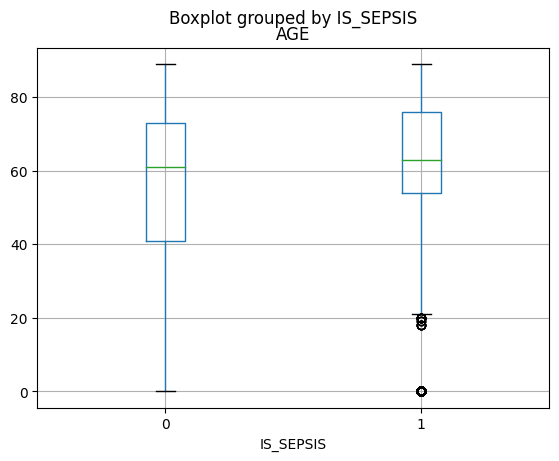

In [11]:
df_demographic.boxplot(column=['AGE'], by='IS_SEPSIS')

Looking at the boxplot we see some outliers in the age feature, some patients around 300 years old.

In [110]:
a = len(df_demographic[df_demographic.AGE>100]['SUBJECT_ID'].unique())
b = len(df_demographic[df_demographic.AGE>100]['SUBJECT_ID'].unique())/len(df_demographic['SUBJECT_ID'].unique())*100
print('The number of patients aged over 100 years old is: {} patients ({:.2f}% over all patients)'.format(a,b))

a = len(df_demographic[(df_demographic.AGE>100) & (df_demographic.IS_SEPSIS==1)]['SUBJECT_ID'].unique())
b = len(df_demographic[(df_demographic.AGE>100) & (df_demographic.IS_SEPSIS==1)]['SUBJECT_ID'].unique())/len(df_demographic[df_demographic.IS_SEPSIS==1]['SUBJECT_ID'].unique())*100
print('- {} of them has sepsis ({:.2f}% over all sepsis patients)'.format(a,b))

a = len(df_demographic[df_demographic.AGE>100])
b = len(df_demographic[df_demographic.AGE>100])/len(df_demographic)*100
print('The number of admissions aged over 100 years old is: {} admissions ({:.2f}% over all admissions)'.format(a,b))

a = len(df_demographic[(df_demographic.AGE>100) & (df_demographic.IS_SEPSIS==1)])
b = len(df_demographic[(df_demographic.AGE>100) & (df_demographic.IS_SEPSIS==1)])/len(df_demographic[df_demographic.IS_SEPSIS==1])*100
print('- {} of them has sepsis ({:.2f}% over all sepsis patients)'.format(a,b))

The number of patients aged over 100 years old is: 1991 patients (4.28% over all patients)
- 345 of them has sepsis (7.22% over all sepsis patients)
The number of admissions aged over 100 years old is: 2616 admissions (4.44% over all admissions)
- 389 of them has sepsis (7.20% over all sepsis patients)


In [10]:
count_over100 = len(df_demographic[df_demographic.AGE>100])
p_over100 = len(df_demographic[df_demographic.AGE>100])/len(df_demographic)*100
median_age = int(df_demographic['AGE'].median())
print('The number of admissions aged over 100 years old is: {} admissions ({:.2f}% over all admissions)'.format(count_over100, p_over100))
print('The median age of patients: {}'.format(median_age))
df_demographic.loc[df_demographic.AGE>100, 'AGE'] = median_age

The number of admissions aged over 100 years old is: 2616 admissions (4.44% over all admissions)
The median age of patients: 61


### Labevents Cleanup empty HADM_ID

In [5]:
# Read LABEVENTS.csv and filter rows where HADM_ID is missing

# Read ADMISSIONS.csv
df_empty_hadm_labevents = df_labevents[df_labevents['HADM_ID'].isnull()]
df_filled_hadm_labevents = df_labevents[pd.to_numeric(df_labevents["HADM_ID"], errors='coerce').notnull()]

df_admissions.sort_values(by=["SUBJECT_ID", "ADMITTIME"], inplace=True)
df_empty_hadm_labevents.sort_values(by=["SUBJECT_ID", "CHARTTIME"], inplace=True)

# Sorting both DataFrames by the keys used for merging

df_admissions['ADMITTIME'] = pd.to_datetime(df_admissions['ADMITTIME'])
df_admissions['DISCHTIME'] = pd.to_datetime(df_admissions['DISCHTIME'])
df_empty_hadm_labevents['CHARTTIME'] = pd.to_datetime(df_empty_hadm_labevents['CHARTTIME']) 

# Merge and fill missing HADM_ID using inner join
merged_data = df_empty_hadm_labevents.merge(df_admissions, on='SUBJECT_ID', how='inner')
mask = (merged_data['CHARTTIME'] >= merged_data['ADMITTIME']) & (merged_data['CHARTTIME'] <= merged_data['DISCHTIME'])
#Main Task
#if charttime falls between admission time and discharge time then replace labevents hadm_id with admissions table

#to show all the rows
merged_data.loc[mask, 'HADM_ID_x'] = merged_data.loc[mask, 'HADM_ID_y']

# Rename the column back to 'HADM_ID'
merged_data.rename(columns={'HADM_ID_x': 'HADM_ID'}, inplace=True)

# Drop unnecessary columns
merged_data.sort_values(by=["ROW_ID_x"], inplace=True)
merged_data.drop(['HADM_ID_y', 'ROW_ID_y'], axis=1, inplace=True)
merged_data.rename(columns={'SUBJECT_ID_y': 'ADMISSION_SUBJECT_ID'}, inplace=True)

filtered_data_hasHADM = merged_data[merged_data['HADM_ID'].notna()].drop_duplicates(subset=['ROW_ID_x']) #NEED TO CHECK IF unnecessary rows are present since we used merge with adissions and lab events before
filtered_data_noHADM = merged_data[merged_data['HADM_ID'].isnull()].drop_duplicates(subset=['ROW_ID_x'])
filtered_data_hasHADM.rename(columns={'ROW_ID_x': 'ROW_ID'}, inplace=True)
filtered_data_noHADM.rename(columns={'ROW_ID_x': 'ROW_ID'}, inplace=True)

row_ids_in_hasHADM = set(filtered_data_hasHADM['ROW_ID'])
filtered_data_noHADM = filtered_data_noHADM[~filtered_data_noHADM['ROW_ID'].isin(row_ids_in_hasHADM)] #Had to refilter filtered_data_noHADM since there were unnecessary rows

columns_to_remove = ['ADMITTIME','DISCHTIME','DEATHTIME', 'ADMISSION_TYPE',  'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE',    'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',   'ETHNICITY', 'EDREGTIME'    ,'EDOUTTIME'    ,'DIAGNOSIS'    ,'HOSPITAL_EXPIRE_FLAG' ,'HAS_CHARTEVENTS_DATA']

# Drop the specified columns
filtered_data_noHADM = filtered_data_noHADM.drop(columns=columns_to_remove)
filtered_data_hasHADM = filtered_data_hasHADM.drop(columns=columns_to_remove)

combined_df_hasHADM = pd.concat([df_filled_hadm_labevents, filtered_data_hasHADM], ignore_index=True)
combined_df_hasHADM['HADM_ID'] = combined_df_hasHADM['HADM_ID'].astype(int)
df_labevents = combined_df_hasHADM

C:\Users\vicky\AppData\Local\Temp\ipykernel_3380\4027779066.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_empty_hadm_labevents.sort_values(by=["SUBJECT_ID", "CHARTTIME"], inplace=True)
C:\Users\vicky\AppData\Local\Temp\ipykernel_3380\4027779066.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_empty_hadm_labevents['CHARTTIME'] = pd.to_datetime(df_empty_hadm_labevents['CHARTTIME'])


In [6]:
my_util.save_csv(df_labevents, ROOT_DIR / 'data/labevents_cleaned.csv')

### draft

In [ ]:
analysis = sv.analyze(df_patient)

In [ ]:
analysis.show_notebook()

In [46]:
df_labevents_processed = load_df.load_labevents_dask(ROOT_DIR)

2023-09-06 10:34:54.416082 Start
2023-09-06 10:34:54.858413 2045381
2023-09-06 10:34:57.505488 End


## 1.2 Data Exploration

### GPT

In [ ]:
prompt = '''
[INST]
You are a medical expert. You are tasked to identify causality between two conditions.
Return yes if A causes B and the rank for causality. If B causes A or if you are not sure, return no. Keep your responses short and succinct.
[/SYS]
Input
{test}
[/INST]
'''
gpt_utils.run(prompt,"A: blood; B: sepsis")
# gpt_utils.chat_with_chatgpt(prompt, "A: White blood cells")

In [178]:
dup_rowid = df_desc_labitems[df_desc_labitems.LABEL.duplicated(keep=False) == True]['ROW_ID'].unique()
df_desc_labitems['FULL_LABEL'] = df_desc_labitems.apply(lambda x: x.LABEL if x['ROW_ID'] not in dup_rowid else f"{x.LABEL} in {x.FLUID} of {x.CATEGORY}", axis=1)

In [ ]:
# events = pd.concat([df_desc_labitems[~df_desc_labitems.ROW_ID.isin(dup_rowid)]['LABEL'], 
#            df_desc_labitems[df_desc_labitems.ROW_ID.isin(dup_rowid)].apply(lambda x: f"{x.LABEL} in {x.FLUID} of {x.CATEGORY}", axis=1)],
#           ignore_index=True)

# df = pd.DataFrame(data=events, columns=['event'])
df_desc_labitems['relation'] = df_desc_labitems.apply(lambda x: gpt_utils.run(prompt, f"A: {x.FULL_LABEL}, B: sepsis"), axis=1)
df_desc_labitems['result'] = df_desc_labitems.apply(lambda x: 'Yes' if 'Yes' in x.relation else 'No', axis=1)
my_util.save_csv(df_desc_labitems, ROOT_DIR / 'data/labevents_gpt.csv')

### Time distribution of a patient's first lab event since admission

In [7]:
df_labevents = df_labevents.sort_values(['HADM_ID', 'CHARTTIME'])
first_labevents = df_labevents.drop_duplicates(['SUBJECT_ID', 'HADM_ID'], keep='first')[['SUBJECT_ID', 'HADM_ID', 'CHARTTIME']]
first_labevent_time = df_demographic[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'IS_SEPSIS', 'ADMISSION_LOCATION']].merge(first_labevents, on=['SUBJECT_ID', 'HADM_ID'])

first_labevent_time.ADMITTIME = pd.to_datetime(first_labevent_time['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
first_labevent_time.CHARTTIME = pd.to_datetime(first_labevent_time['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')

first_labevent_time['TIME'] = np.where(first_labevent_time.CHARTTIME > first_labevent_time.ADMITTIME,
                      np.ceil((first_labevent_time.CHARTTIME - first_labevent_time.ADMITTIME).dt.total_seconds() / 3600),
                      np.floor((first_labevent_time.CHARTTIME - first_labevent_time.ADMITTIME).dt.total_seconds() / 3600))

In [12]:
len(first_labevent_time[(first_labevent_time.TIME <= 10) & (first_labevent_time.TIME >= -10)])/len(first_labevent_time)

0.9308661498530347

In [20]:
len((first_labevent_time[first_labevent_time.IS_SEPSIS==1])[(first_labevent_time.TIME <= 10) & (first_labevent_time.TIME >= -10)])/len(first_labevent_time[first_labevent_time.IS_SEPSIS==1])

C:\Users\vicky\AppData\Local\Temp\ipykernel_3380\2062131203.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len((first_labevent_time[first_labevent_time.IS_SEPSIS==1])[(first_labevent_time.TIME <= 10) & (first_labevent_time.TIME >= -10)])/len(first_labevent_time[first_labevent_time.IS_SEPSIS==1])


0.960577456968351

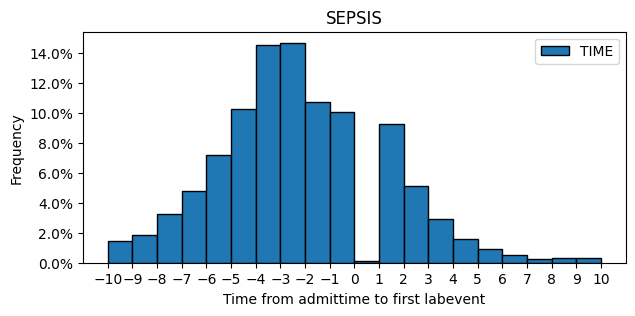

In [110]:
sepsis_have_labvents_in10h = first_labevent_time[(first_labevent_time.TIME <= 10) & (first_labevent_time.TIME >= -10) & (first_labevent_time.IS_SEPSIS==1)]
sepsis_have_labvents_in10h.\
  plot(kind='hist', y='TIME', bins=20, \
       weights=np.ones(len(sepsis_have_labvents_in10h)) / len(sepsis_have_labvents_in10h),\
       xticks=list(range(-10, 11)), \
       edgecolor='black', title='SEPSIS', xlabel='Time from admittime to first labevent', figsize=(7, 3))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [75]:
step = 1
bin_range = np.arange(-10, 10+step, step)
out, bins  = pd.cut(sepsis_have_labvents_in10h['TIME'], bins=bin_range, include_lowest=True, right=False, retbins=True)

<Axes: xlabel='TIME'>

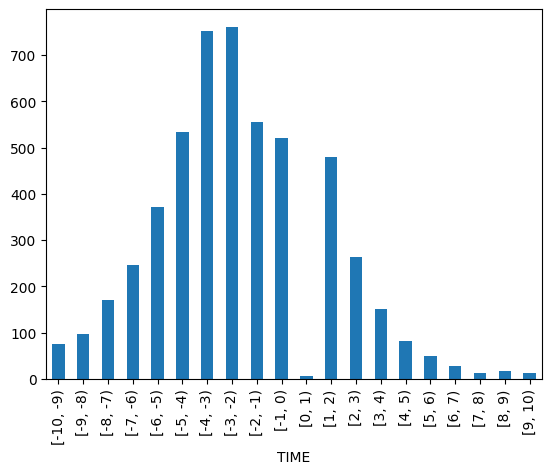

In [104]:
out.value_counts().sort_index().plot.bar()

<Axes: xlabel='ADMISSION_LOCATION'>

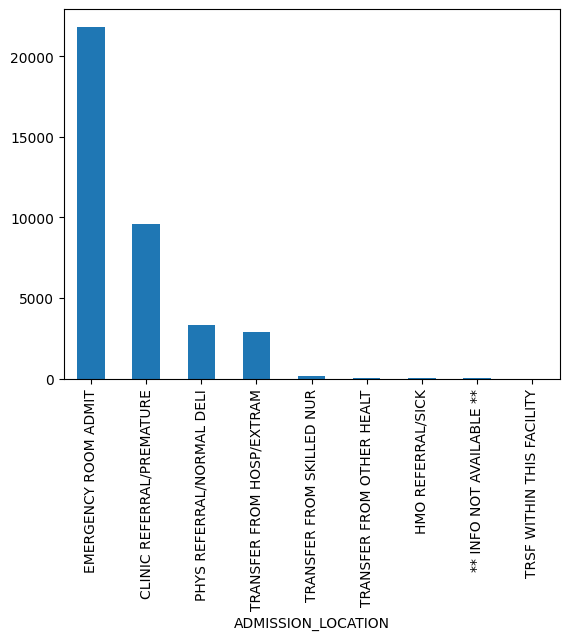

In [70]:
first_labevent_time[first_labevent_time.TIME<0]['ADMISSION_LOCATION'].value_counts().plot(kind='bar')

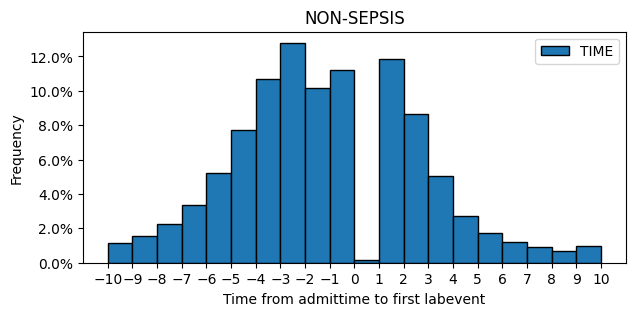

In [108]:
nonsepsis_have_labvents_in10h = first_labevent_time[(first_labevent_time.TIME <= 10) & (first_labevent_time.TIME >= -10) & (first_labevent_time.IS_SEPSIS==0)]
nonsepsis_have_labvents_in10h.\
  plot(kind='hist', y='TIME', bins=20, \
       weights=np.ones(len(nonsepsis_have_labvents_in10h)) / len(nonsepsis_have_labvents_in10h),\
       xticks=list(range(-10, 11)), \
       edgecolor='black', title='NON-SEPSIS', xlabel='Time from admittime to first labevent', figsize=(7, 3))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

### Top 10 common labvents tested for sepsis patient

In [118]:
from collections import Counter
import datetime

def compute_common_test(x, hours=-99):
  x = x.sort_values(['CHARTTIME'])
  if hours <= 0:
    return x['ITEMID'].unique()
  else:
    target_time = x.iloc[0]['CHARTTIME'] + pd.DateOffset(hours=hours)
    return x[x.CHARTTIME <= target_time]['ITEMID'].unique()

def get_top_common_labevents(hours, top_n, IS_SEPSIS=1):
  labevents_with_issepsis = df_labevents.merge(df_demographic[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']], on=['SUBJECT_ID', 'HADM_ID'])
  item_list = labevents_with_issepsis[labevents_with_issepsis.IS_SEPSIS==IS_SEPSIS].groupby(['SUBJECT_ID', 'HADM_ID']).apply(lambda x: compute_common_test(x, hours))
  all_itemid = [itemid for sublist in item_list.values for itemid in sublist]
  value_counts = Counter(all_itemid).most_common(top_n)

  most_common_test_for_sepsis = pd.DataFrame({'ITEMID': [item[0] for item in value_counts],\
                                              'LABEL': df_desc_labitems[df_desc_labitems.ITEMID.isin([item[0] for item in value_counts])]['LABEL'],\
                                                'COUNT': [item[1] for item in value_counts]})
  return most_common_test_for_sepsis

In [119]:
get_top_common_labevents(hours=4, top_n=15, IS_SEPSIS=1)

,ITEMID,LABEL,COUNT
209,51221,Bicarbonate,5181
229,51301,Chloride,5155
239,51265,Creatinine,5142
298,51222,Potassium,5136
310,51249,Sodium,5135
332,51250,Urea Nitrogen,5135
547,51279,Hematocrit,5135
548,51248,Hemoglobin,5135
574,51277,MCH,5130
575,50912,MCHC,4939


## 1.3 Feature Selection

In [284]:
def create_potential_events_file(potential_icd9_code_file, hours=48):
  # potential_icd9_code = pd.read_csv(ROOT_DIR / 'data/potential_icd9.csv')
  potential_icd9_code = pd.read_csv(potential_icd9_code_file)
  potential_icd9_code.ICD9_CODE = potential_icd9_code.ICD9_CODE.astype('str')

  potential_cases = df_diagnoses_icd[df_diagnoses_icd.ICD9_CODE.isin(potential_icd9_code.ICD9_CODE)][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']].drop_duplicates(['SUBJECT_ID', 'HADM_ID'])
  potential_cases = df_demographic[df_demographic.IS_SEPSIS==1][['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'IS_SEPSIS']].merge(potential_cases[['SUBJECT_ID', 'HADM_ID']])
  potential_cases = df_labevents.merge(potential_cases, on=['SUBJECT_ID', 'HADM_ID'])[['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'ADMITTIME', 'CHARTTIME', 'FLAG']]

  potential_cases['TIME'] = np.where(potential_cases.CHARTTIME > potential_cases.ADMITTIME,
                        np.ceil((potential_cases.CHARTTIME - potential_cases.ADMITTIME).dt.total_seconds() / 3600),
                        np.floor((potential_cases.CHARTTIME - potential_cases.ADMITTIME).dt.total_seconds() / 3600))
  potential_cases = potential_cases[(potential_cases.TIME <= hours) & (potential_cases.TIME >= -hours)]
  potential_cases = potential_cases.merge(df_desc_labitems[['ITEMID', 'LABEL', 'FLUID']], on=['ITEMID'])
  
  out_file_abnormal = ROOT_DIR / 'data/output_csv/potential_events_abnormal.csv'
  out_file_others = ROOT_DIR / 'data/output_csv/potential_events_others.csv'
  my_util.save_csv(potential_cases[potential_cases.FLAG == 'abnormal'], out_file_abnormal)
  my_util.save_csv(potential_cases[potential_cases.FLAG != 'abnormal'], out_file_others)
  return [out_file_abnormal, out_file_others]

In [285]:
create_potential_events_file(ROOT_DIR / 'data/potential_icd9.csv')

[WindowsPath('../../data/output_csv/potential_events_abnormal.csv'),
 WindowsPath('../../data/output_csv/potential_events_others.csv')]

In [280]:
sepsis_cases = df_diagnoses_icd[df_diagnoses_icd.IS_SEPSIS == 1].drop_duplicates(['SUBJECT_ID', 'HADM_ID'])[['SUBJECT_ID', 'HADM_ID']]
sepsis_cases = sepsis_cases.merge(df_diagnoses_icd[df_diagnoses_icd.IS_SEPSIS != 1][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']], on=['SUBJECT_ID', 'HADM_ID'])
sepsis_cases = sepsis_cases.merge(df_desc_icd[['ICD9_CODE', 'SHORT_TITLE']], on='ICD9_CODE')
common_icd = sepsis_cases.groupby(['ICD9_CODE', 'SHORT_TITLE']).apply(lambda x: len(x.drop_duplicates(['SUBJECT_ID', 'HADM_ID']))).sort_values(ascending=False).reset_index(name='COUNT')
common_icd = common_icd.head(20)
my_util.save_csv(common_icd, ROOT_DIR / 'data/potential_icd9.csv')